# 0. Import library and load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
sns.set(style="whitegrid")

df = pd.read_csv("../data/raw/surat_uncleaned.csv")

# 1. Dataset overview

## 1.1. Basic information

In [54]:
df.head()

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644 sqft,New Property,Poss. by Oct '24,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...","₹2,891 per sqft",₹33.8 Lac
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278 sqft,New Property,Poss. by Jan '26,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,"₹3,551 per sqft",₹45.4 Lac
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173 sqft,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,"₹3,800 per sqft",₹44.6 Lac
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700 sqft,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,"₹3,966 per sqft",₹47 Lac
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250 sqft,Orchid Fantasia,New Property,Unfurnished,2,2,"Multistorey Apartment for Sale in Palanpur, Su...","₹3,600 per sqft",₹45 Lac


In [55]:
df.info()
print("Approx. size (MB):", df.memory_usage(deep=True).sum()/(1024**2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   property_name   4525 non-null   object
 1   areaWithType    4525 non-null   object
 2   square_feet     4525 non-null   object
 3   transaction     4421 non-null   object
 4   status          4524 non-null   object
 5   floor           4480 non-null   object
 6   furnishing      4185 non-null   object
 7   facing          3936 non-null   object
 8   description     3154 non-null   object
 9   price_per_sqft  4157 non-null   object
 10  price           4525 non-null   object
dtypes: object(11)
memory usage: 389.0+ KB
Approx. size (MB): 4.137722015380859


In [56]:
df.sample(5)

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
3048,4 BHK Villa for Sale in JT Nagar Surat,Carpet Area,2000 sqft,3,Ready to Move,Semi-Furnished,NaN,NaN,"4 BHK, Villa is available for Sale in JT Nagar...",NaN,₹1.50 Cr
2473,"3 BHK Apartment for Sale in Sun Sarvam, Vesu S...",Super Area,1925 sqft,Unfurnished,Poss. by Aug '24,New Property,Sun Sarvam,3,"Multistorey Apartment for Sale in Vesu, Surat....","₹4,751 per sqft",₹91.5 Lac
3833,Showroom for Sale in Ram Nagar Surat,Carpet Area,600 sqft,Resale,Ready to Move,Ground out of 1,NaN,NaN,Commercial showroom is available for sale. It ...,"₹35,000 per sqft",₹2.10 Cr
2315,"3 BHK Apartment for Sale in Times Luxuria, Ves...",Carpet Area,1179 sqft,Resale,Ready to Move,11 out of 12,Unfurnished,East,Ready to move 3BHK apartment with all modern a...,"₹4,620 per sqft",₹99 Lac
2040,2 BHK House for Sale in Majura Gate Surat,Carpet Area,90 acre,Furnished,Ground out of 1,Resale,2,NaN,NaN,₹1 per sqft,₹50 Lac


- **Number of rows:** The dataset contains **4,525 rows** (index ranges from **0** to **4,524**).
- **Number of columns:** The dataset contains **11 columns**.

- **What does each row represent?**  
  Each row corresponds to **one real-estate property listing** in Surat. This is supported by the `property_name` field (e.g., “2 BHK Apartment for Sale in … Surat”), while the remaining columns describe the listing’s attributes such as area, transaction/status, floor, furnishing/facing, a short description, and pricing information.

- **Overall dataset size:**  
  The DataFrame’s memory footprint is approximately **4.2 MB**.

- **Quick structural note (from `df.info()`):**  
  All **11 columns are stored as `object` type**, indicating that many values are currently represented as text (e.g., `"644 sqft"`, `"₹2,891 per sqft"`, `"₹33.8 Lac"`). This is expected for an *uncleaned* dataset and suggests that type conversion and text parsing will be required during preprocessing.

## 1.2. Data Integrity

In [57]:
dup_full = df.duplicated().sum()
empty_rows = df.isna().all(axis=1).sum()

print("Duplicated rows:", dup_full)
print("Fully empty rows:", empty_rows)

Duplicated rows: 109
Fully empty rows: 0


These duplicates should **be removed** because each row represents a single property listing. Exact duplicates most likely come from repeated scraping/entries and would **inflate the frequency** of certain listings, biasing distribution-based analyses (e.g., price, area) and potentially harming model training by over-representing repeated records.

## 1.3. Column Inventory 

In [58]:
def column_inventory(df, top_k=5):
    inv = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "missing_count": df.isna().sum().values,
        "missing_pct": (df.isna().mean() * 100).round(2).values,
        "n_unique": df.nunique(dropna=True).values,
        "example": [
            df[c].dropna().iloc[0] if df[c].notna().any() else np.nan
            for c in df.columns
        ],
    })

    # Add top categories for object columns
    top_values = {}
    for c in df.columns:
        if df[c].dtype == "object":
            vc = df[c].astype(str).str.strip().replace("nan", np.nan).value_counts(dropna=True).head(top_k)
            top_values[c] = ", ".join([f"{idx} ({val})" for idx, val in vc.items()])
        else:
            top_values[c] = ""
    inv["top_values"] = inv["column"].map(top_values)

    return inv.sort_values("missing_pct", ascending=False)

inventory = column_inventory(df, top_k=5)
inventory

,column,dtype,missing_count,missing_pct,n_unique,example,top_values
8,description,object,1371,30.30,2588,"Luxury project with basement parking, Solar ro...",Multistorey apartment is available for sale. I...
7,facing,object,589,13.02,176,West,"East (1487), South -West (354), 2 (329), 1 (25..."
9,price_per_sqft,object,368,8.13,2134,"₹2,891 per sqft","₹6,000 per sqft (64), ₹5,000 per sqft (64), ₹4..."
6,furnishing,object,340,7.51,78,Unfurnished,"Unfurnished (2322), Semi-Furnished (491), Furn..."
3,transaction,object,104,2.30,38,New Property,"Resale (2197), New Property (1486), Unfurnishe..."
5,floor,object,45,0.99,222,5 out of 10,"Resale (431), New Property (267), 5 out of 13 ..."
4,status,object,1,0.02,138,Poss. by Oct '24,"Ready to Move (3078), Poss. by Dec '24 (155), ..."
0,property_name,object,0,0.00,1992,2 BHK Apartment for Sale in Dindoli Surat,"3 BHK Apartment for Sale in Vesu Surat (93), 3..."
1,areaWithType,object,0,0.00,6,Carpet Area,"Super Area (2599), Carpet Area (1671), Plot Ar..."
2,square_feet,object,0,0.00,1399,644 sqft,"1000 sqft (77), 800 sqft (64), 1100 sqft (62),..."


In [59]:
# 1) High-missing columns (tune threshold as needed)
high_missing = inventory[inventory["missing_pct"] > 30]["column"].tolist()

# 2) Near-constant columns (not expected here, but good practice)
near_constant = inventory[inventory["n_unique"] <= 1]["column"].tolist()

print("High-missing (>30%) candidates:", high_missing)
print("Near-constant candidates:", near_constant)

High-missing (>30%) candidates: ['description']
Near-constant candidates: []


### Meaning / definition of each column
The dataset contains 11 columns describing one property listing in Surat:

- **property_name**: Listing headline (often includes BHK + property type + locality).
- **areaWithType**: Declared area type (e.g., *Super Area*, *Carpet Area*, *Plot Area*).
- **square_feet**: Property size stored as text with units (e.g., “1000 sqft”); should be parsed to numeric `area_sqft`.
- **transaction**: Transaction type (expected: *New Property* / *Resale*).
- **status**: Availability/possession status (e.g., *Ready to Move*, *Poss. by Oct '24*).
- **floor**: Floor information (e.g., “5 out of 10”); should be parsed to `floor_num` and `total_floors`.
- **furnishing**: Furnishing level (e.g., *Unfurnished*, *Semi-Furnished*, *Furnished*).
- **facing**: Direction the property faces (e.g., *East*, *West*, *South-West*).
- **description**: Free-text description of features/amenities.
- **price_per_sqft**: Price per sqft in text format (e.g., “₹2,891 per sqft”); should be parsed to numeric.
- **price**: Listing price in text format (e.g., “₹33.8 Lac”, “₹1.29 Cr”, “Call for Price”); main target after conversion.

### Column relevance for potential analysis
Based on missingness and uniqueness from the inventory table:

- **Core variables for pricing analysis / modeling**
  - `price` (target; note “Call for Price” is a placeholder and should be treated as missing for numeric analysis)
  - `square_feet` (key driver after parsing to numeric)
  - `transaction`, `status`, `furnishing`, `facing`, `floor`, `areaWithType` (important categorical/structured factors)

- **Helpful but requires feature extraction**
  - `property_name` (high-cardinality text: 1,992 unique values). Useful to extract structured features such as `bhk`, `property_type`, and locality keywords.

- **Optional / scope-dependent**
  - `description` (text-heavy and **30.30% missing**; 2,588 unique). Useful only if we plan to do basic NLP/keyword features; otherwise optional.

### Data quality notes from the inventory (important findings)
- **Missingness**
  - `description` has the highest missing rate (**30.30%**, 1,371 missing), making it the primary “high-missing” column.
  - Moderate missing appears in `facing` (**13.02%**) and `price_per_sqft` (**8.13%**) and `furnishing` (**7.51%**).
  - `areaWithType`, `square_feet`, `price`, and `property_name` have **0% missing**.

- **High cardinality / string-numeric issues**
  - `price_per_sqft` has **2,134 unique** values and is stored as text, indicating it behaves like a numeric column but requires parsing and cleaning.
  - `square_feet` has **1,399 unique** values, also text-based numeric with units.

- **Potential column contamination (red flag)**
  - The most frequent values suggest some columns contain unexpected categories:
    - `transaction` includes values that look like furnishing categories (e.g., “Unfurnished”).
    - `floor` shows top values such as “Resale” and “New Property”, which should belong to `transaction`.
    - `facing` contains numeric-like categories (e.g., “2”, “1”), which are not valid facing directions.
  - This indicates **inconsistent entries and likely misaligned/shifted values** in a subset of rows, which must be handled during preprocessing (rule-based validation + set invalid values to NaN/Other).

### Columns that could be dropped
- **`description`** is the main drop candidate:
  - Highest missing rate (**30.30%**) and free-text complexity.
  - We are not doing text/NLP features, so dropping it simplifies preprocessing and reduces noise for ML.

- **`property_name`** should not be dropped immediately:
  - Recommended approach: **extract structured features** (e.g., BHK/property type/locality) first, then optionally drop the raw text column for modeling.

- **`price_per_sqft`** should be used carefully:
  - Useful for EDA and consistency checks.
  - For a price prediction model, it may introduce **data leakage** if it is derived from `price` and `square_feet`. We will consider excluding it from the ML feature set when predicting `price`.

## 1.4. Data Types

In [60]:
target_mapping = {
    'property_name':  'String (Text)',
    'areaWithType':   'Categorical',
    'square_feet':    'Numeric (Float)',
    'transaction':    'Categorical',
    'status':         'Categorical',
    'floor':          'Numeric',
    'furnishing':     'Categorical',
    'facing':         'Categorical',
    'description':    'String (Text)',
    'price_per_sqft': 'Numeric (Float)',
    'price':          'Numeric (Float)'
}

type_analysis_data = []

for col in df.columns:
    current_dtype = df[col].dtype
    example_val = df[col].dropna().iloc[0] if not df[col].dropna().empty else "NaN"
    target_dtype = target_mapping.get(col, "Unknown")
    
    needs_conversion = (str(current_dtype) == 'object') and \
                       (target_dtype != 'String (Text)')
    
    reason = ""
    if needs_conversion:
        if 'Numeric' in target_dtype:
            reason = "Contains units/symbols (₹, sqft, commas, text)"
        elif 'Categorical' in target_dtype:
            reason = "High repetition, better memory usage as category"

    type_analysis_data.append({
        'Column': col,
        'Current Dtype': str(current_dtype),
        'Example Value': example_val,
        'Target Dtype': target_dtype,
        'Needs Conversion': needs_conversion,
        'Reason': reason
    })

type_analysis_df = pd.DataFrame(type_analysis_data)
display(type_analysis_df)

,Column,Current Dtype,Example Value,Target Dtype,Needs Conversion,Reason
0,property_name,object,2 BHK Apartment for Sale in Dindoli Surat,String (Text),False,
1,areaWithType,object,Carpet Area,Categorical,True,"High repetition, better memory usage as category"
2,square_feet,object,644 sqft,Numeric (Float),True,"Contains units/symbols (₹, sqft, commas, text)"
3,transaction,object,New Property,Categorical,True,"High repetition, better memory usage as category"
4,status,object,Poss. by Oct '24,Categorical,True,"High repetition, better memory usage as category"
5,floor,object,5 out of 10,Numeric,True,"Contains units/symbols (₹, sqft, commas, text)"
6,furnishing,object,Unfurnished,Categorical,True,"High repetition, better memory usage as category"
7,facing,object,West,Categorical,True,"High repetition, better memory usage as category"
8,description,object,"Luxury project with basement parking, Solar ro...",String (Text),False,
9,price_per_sqft,object,"₹2,891 per sqft",Numeric (Float),True,"Contains units/symbols (₹, sqft, commas, text)"


### Current Data Type Status
Based on our detailed type analysis, **all 11 columns** in the dataset are currently stored as `object` (string). While this is common for raw web-scraped data, it is inappropriate for data analysis because mathematical operations (e.g., calculating average price) and statistical summaries cannot be performed on text strings.

### Inappropriate Data Types & Conversion Plan
We have identified that **9 out of 11 columns** require type conversion. The table below details the specific issues found in the raw data and our target data types:

| Column | Current Dtype | Example Value | Target Dtype | Issue / Reason for Conversion |
| :--- | :--- | :--- | :--- | :--- |
| **square_feet** | Object | `644 sqft` | **Float** | Contains non-numeric units ("sqft") preventing numerical calculation. |
| **price** | Object | `₹33.8 Lac` | **Float** | Contains currency symbols (`₹`), units (`Lac`, `Cr`), and text placeholders like "Call for Price". |
| **price_per_sqft**| Object | `₹2,891 per sqft`| **Float** | Contains currency symbols (`₹`), text (`per sqft`), and commas. |
| **floor** | Object | `5 out of 10` | **Numeric (Split)**| Contains compound information (Current Floor + Total Floors) as a string. Needs parsing. |
| **transaction** | Object | `New Property` | **Category** | High repetition of values. Converting to Category reduces memory usage and improves semantics. |
| **status** | Object | `Poss. by Oct '24`| **Category** | Represents a finite set of project states. |
| **furnishing** | Object | `Unfurnished` | **Category** | Represents ordinal/nominal categories suitable for encoding. |
| **facing** | Object | `West` | **Category** | Represents nominal directional categories. |
| **areaWithType** | Object | `Carpet Area` | **Category** | Represents nominal area definitions. |

*Note: `property_name` and `description` will remain as **String (Text)** objects as they are unstructured text fields.*

### Conversion Strategy
To prepare the dataset for the **Data Analysis** phase, we will implement the following preprocessing steps:

1.  **Numerical Parsing:**
    * **Price Cleaning:** We must handle Indian numbering units where `Lac` = 100,000 and `Cr` (Crore) = 10,000,000 to convert strings like "₹33.8 Lac" into actual integers (e.g., 3,380,000). Rows with "Call for Price" will be treated as missing values.
    * **Unit Removal:** Remove **"sqft"**, **"₹"**, and commas from `square_feet` and `price_per_sqft`.

2.  **Structural Parsing:**
    * The `floor` column will be split into two new numerical features: `floor_level` (numerator) and `total_floors` (denominator).

3.  **Categorical Casting:**
    * Columns with low cardinality (`transaction`, `status`, `furnishing`, `facing`, `areaWithType`) will be standardized and converted to the `category` data type to optimize performance and enable categorical plotting.

# 2. Numerical Columns Analysis 

## 2.1 Convert numerical column

In [61]:
tmp = df.copy()
def parse_area_sqft(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).strip().lower().replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    if not m:
        return np.nan
    num = float(m.group(1))
    # unit detection
    if "sqft" in t:
        return num
    if "sqyd" in t or "sqyrd" in t:
        return num * 9
    if "sqm" in t or "sq.m" in t:
        return num * 10.7639
    if "acre" in t:
        return num * 43560
    if "rood" in t:
        return num * 10890
    if "ground" in t:
        return num * 2400
    return np.nan

def parse_ppsqft(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).lower().replace("₹", "").replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    return float(m.group(1)) if m else np.nan

def parse_price_lakh(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).strip().lower()
    if t == "call for price":
        return np.nan
    t = t.replace("₹", "").replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    if not m:
        return np.nan
    num = float(m.group(1))
    # unit conversion
    if "cr" in t:        # crore
        return num * 100
    if "lac" in t or "lakh" in t:
        return num
    # unknown → NaN
    return np.nan

def parse_bhk_from_name(s):
    if pd.isna(s):
        return np.nan
    m = re.search(r"(\d+)\s*bhk", str(s), flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

def parse_floor(s):
    if pd.isna(s):
        return (np.nan, np.nan)
    t = str(s).strip().lower()

    # quick filter: only attempt parsing if pattern contains "out of"
    if "out of" not in t:
        return (np.nan, np.nan)

    # handle "ground out of X"
    if t.startswith("ground"):
        m = re.search(r"ground\s*out\s*of\s*(\d+)", t)
        if m:
            return (0.0, float(m.group(1)))
        return (np.nan, np.nan)

    # normal case: "5 out of 13"
    m = re.search(r"(\d+)\s*out\s*of\s*(\d+)", t)
    if m:
        return (float(m.group(1)), float(m.group(2)))

    return (np.nan, np.nan)

tmp["area_sqft"]  = tmp["square_feet"].apply(parse_area_sqft)
tmp["ppsqft"]     = tmp["price_per_sqft"].apply(parse_ppsqft)
tmp["price_lakh"] = tmp["price"].apply(parse_price_lakh)
tmp["bhk"]        = tmp["property_name"].apply(parse_bhk_from_name)
tmp[["floor_num", "total_floors"]] = tmp["floor"].apply(parse_floor).apply(pd.Series)
tmp["floor_ratio"] = tmp["floor_num"] / tmp["total_floors"]

tmp[["area_sqft","ppsqft","price_lakh","bhk","floor_ratio"]].head()

,area_sqft,ppsqft,price_lakh,bhk,floor_ratio
0,644.0,2891.0,33.8,2.0,0.500000
1,1278.0,3551.0,45.4,2.0,0.428571
2,1173.0,3800.0,44.6,2.0,0.384615
3,700.0,3966.0,47.0,2.0,0.428571
4,1250.0,3600.0,45.0,2.0,NaN


In [62]:
num_cols = ["area_sqft", "ppsqft", "price_lakh", "bhk", "floor_num", "total_floors", "floor_ratio"]

summary = pd.DataFrame({
    "missing_count": tmp[num_cols].isna().sum(),
    "missing_pct": (tmp[num_cols].isna().mean()*100).round(2),
    "mean": tmp[num_cols].mean(numeric_only=True),
    "median": tmp[num_cols].median(numeric_only=True),
    "std": tmp[num_cols].std(numeric_only=True),
    "min": tmp[num_cols].min(numeric_only=True),
    "max": tmp[num_cols].max(numeric_only=True),
}).reset_index().rename(columns={"index":"column"})

summary

,column,missing_count,missing_pct,mean,median,std,min,max
0,area_sqft,6,0.13,6782.268609,1283.0,162541.774733,1.0,8400000.0
1,ppsqft,368,8.13,9478.185230,4700.0,194058.626189,1.0,12500000.0
2,price_lakh,173,3.82,132.082376,71.0,856.328971,1.0,53444.0
3,bhk,636,14.06,2.840833,3.0,1.092492,1.0,10.0
4,floor_num,908,20.07,4.868399,5.0,3.385834,0.0,20.0
5,total_floors,908,20.07,9.582803,12.0,4.736691,1.0,30.0
6,floor_ratio,908,20.07,0.495615,0.5,0.286118,0.0,1.0


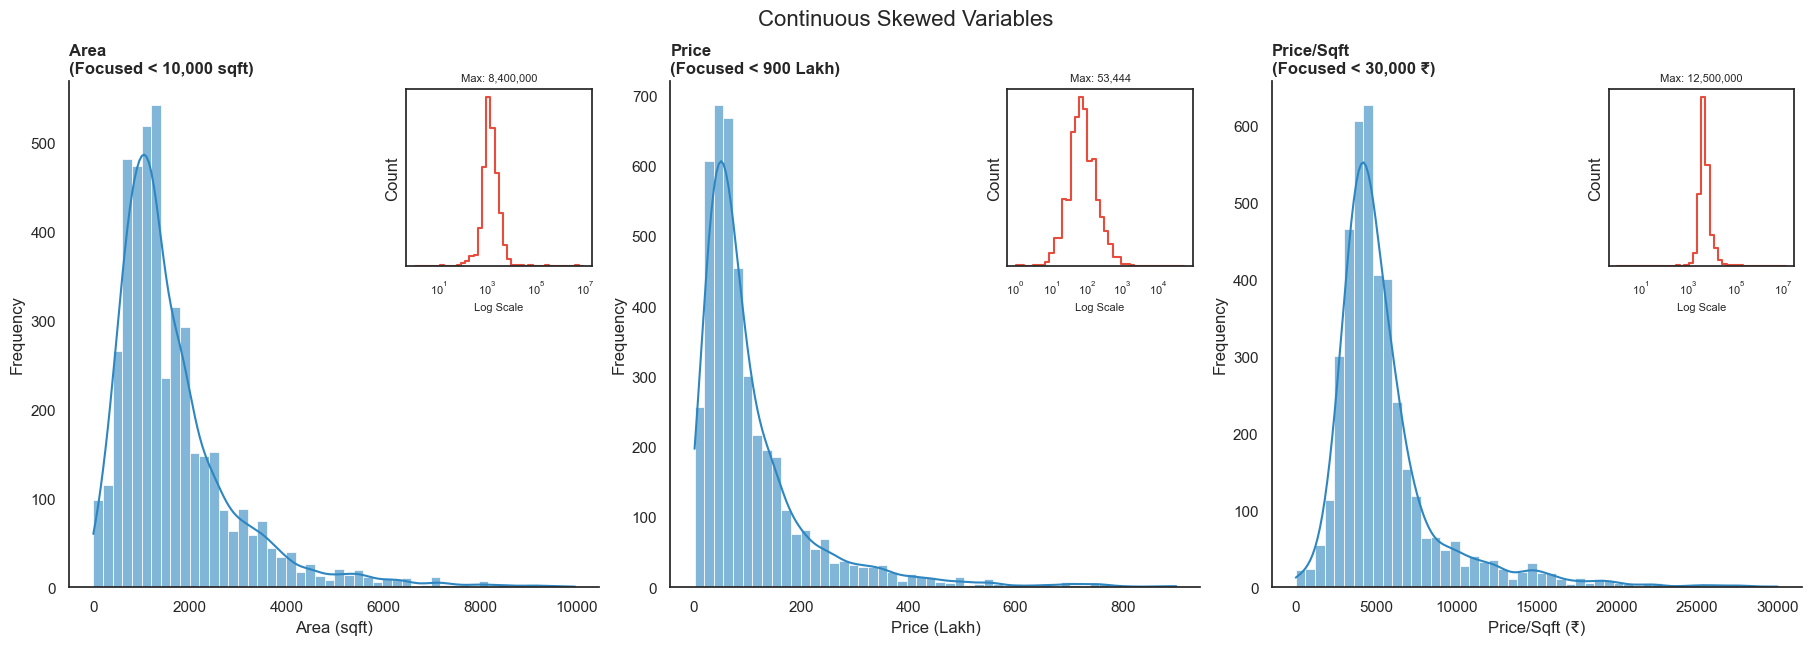

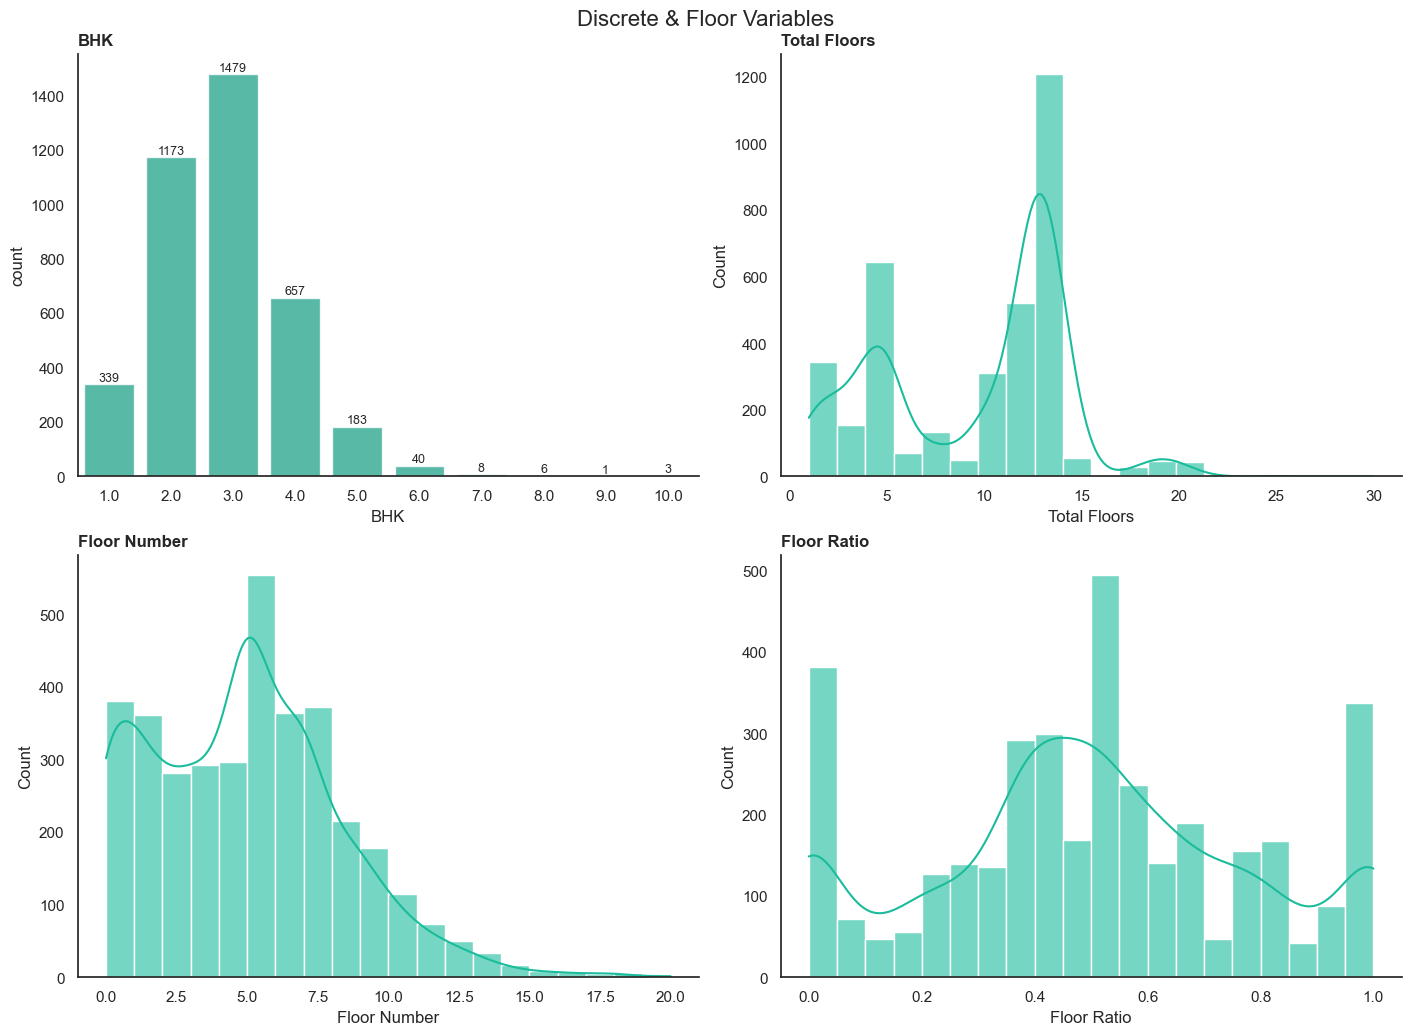

In [83]:
def plot_skewed_group_subplot(ax, col, title, limit, unit):
    data = tmp[col].dropna()
    data_zoom = data[data <= limit]
    
    # --- MAIN PLOT (ZOOMED)'ax' ---
    sns.histplot(data_zoom, bins=50, kde=True, color="#2E86C1", alpha=0.6, ax=ax)
    
    ax.set_title(f"{title}\n(Focused < {limit:,.0f} {unit})", fontsize=12, weight='bold', loc='left')
    ax.set_xlabel(f"{title} ({unit})")
    ax.set_ylabel("Frequency")
    sns.despine(ax=ax)

    # --- INSET PLOT (LOG SCALE) ---
    ax_ins = inset_axes(ax, width="35%", height="35%", loc='upper right')
    sns.histplot(data, bins=40, color="#E74C3C", ax=ax_ins, log_scale=True, element="step", fill=False)
    
    ax_ins.set_title(f"Max: {data.max():,.0f}", fontsize=8)
    ax_ins.set_xlabel("Log Scale", fontsize=8)
    ax_ins.set_yticks([]) 
    ax_ins.tick_params(axis='x', labelsize=8)

def plot_discrete_group_subplot(ax, col, title, color="#1ABC9C"):
    data = tmp[col].dropna()
    
    if data.nunique() <= 15:
        sns.countplot(x=data, ax=ax, color=color, alpha=0.8)
        ax.bar_label(ax.containers[0], fontsize=9)
    else:
        sns.histplot(data, bins=20, kde=True, ax=ax, color=color, alpha=0.6)

    ax.set_title(f"{title}", fontsize=12, weight='bold', loc='left')
    ax.set_xlabel(title)
    sns.despine(ax=ax)

group1_configs = [
    ('area_sqft', 'Area', 10000, 'sqft'),
    ('price_lakh', 'Price', 900, 'Lakh'),
    ('ppsqft', 'Price/Sqft', 30000, '₹')
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)
fig.suptitle('Continuous Skewed Variables', fontsize=16, y=1.05)
for ax, (col, title, limit, unit) in zip(axes, group1_configs):
    plot_skewed_group_subplot(ax, col, title, limit, unit)
plt.show()

group2_cols = [
    ('bhk', 'BHK'),
    ('total_floors', 'Total Floors'),
    ('floor_num', 'Floor Number'),
    ('floor_ratio', 'Floor Ratio')
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), constrained_layout=True)
fig.suptitle('Discrete & Floor Variables', fontsize=16, y=1.02)
for ax, (col, title) in zip(axes.flatten(), group2_cols):
    plot_discrete_group_subplot(ax, col, title)
plt.show()